# Data analysis

This notebook provides the procedure for analyzing code generation results and generating the charts used in the paper.

First run the following to compile the analysis code:

In [2]:
import json
import math

from collections import defaultdict
from typing import Optional

from numpy import average

def log_solution_stats(solutions_path: str) -> str:
    '''
    We log stats such as the proportion of problems solved and the confusion matrix
    '''
    stats_dict = {}

    solved_problems = 0
    any_solved_problems = 0
    total_problems = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    sum_cosine_similarity = 0.0
    sum_avg_score = 0.0
    sum_tfidf_similarity = 0.0
    sum_levenshtein_similarity = 0.0
    sum_token_sequence_similarity = 0.0
    scores = []
    is_solved_list = []
    sum_scores_length = 0
    solved_index_frequency = defaultdict(int)
    sum_output_tokens = 0
    sum_total_tokens = 0
    sum_requests = 0

    solved_output_token_frequency = defaultdict(int)
    solved_request_frequency = defaultdict(int)

    with open(solutions_path, 'r') as file:
        for line in file:
            solution_dict = json.loads(line)
            
            if solution_dict['is_solved']:
                solved_problems += 1
            if 'any_solved' in solution_dict['extra_kwargs']:
                if solution_dict['extra_kwargs']['any_solved']:
                    any_solved_problems += 1
            if solution_dict['is_solved'] and solution_dict['is_passing']:
                true_positive += 1
            elif not solution_dict['is_solved'] and not solution_dict['is_passing']:
                true_negative += 1
            elif solution_dict['is_solved'] and not solution_dict['is_passing']:
                false_negative += 1
            elif not solution_dict['is_solved'] and solution_dict['is_passing']:
                false_positive += 1

            if 'cosine_similarity' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['cosine_similarity']
                # check if solution_dict['extra_kwargs']['cosine_similarity'] is a number that is not NaN or infinite
                if isinstance(value, (int, float)) and not (math.isnan(value) or math.isinf(value)):
                    sum_cosine_similarity += value
            if 'avg_score' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['avg_score']
                if isinstance(value, (int, float)) and not (math.isnan(value) or math.isinf(value)):
                    sum_avg_score += value
            if 'tfidf_similarity' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['tfidf_similarity']
                if isinstance(value, (int, float)) and not (math.isnan(value) or math.isinf(value)):
                    sum_tfidf_similarity += value
            if 'levenshtein_similarity' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['levenshtein_similarity']
                if isinstance(value, (int, float)) and not (math.isnan(value) or math.isinf(value)):
                    sum_levenshtein_similarity += value
            if 'token_sequence_similarity' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['token_sequence_similarity']
                if isinstance(value, (int, float)) and not (math.isnan(value) or math.isinf(value)):
                    sum_token_sequence_similarity += value

            if 'scores' in solution_dict['extra_kwargs']:
                values = solution_dict['extra_kwargs']['scores']
                # fill values with 1.0 until it is same length as scores
                values += [1.0] * (len(scores) - len(values))
                # fill scores with float(total_problems) until it is same length as values
                scores += [float(total_problems)] * (len(values) - len(scores))
                scores = [a + b for a, b in zip(scores, values)]
                sum_scores_length += len(values)

            if 'is_solved_list' in solution_dict['extra_kwargs']:
                values = solution_dict['extra_kwargs']['is_solved_list']
                # fill values with 1 until it is same length as is_solved_list
                values += [1] * (len(is_solved_list) - len(values))
                # fill is_solved_list with 1 until it is same length as values
                is_solved_list += [1] * (len(values) - len(is_solved_list))
                is_solved_list = [a + int(b) for a, b in zip(is_solved_list, values)]

            if 'solved_index' in solution_dict['extra_kwargs']:
                value = solution_dict['extra_kwargs']['solved_index']
                solved_index_frequency[value] += 1

            if 'output_tokens' in solution_dict['extra_kwargs']:
                sum_output_tokens += solution_dict['extra_kwargs']['output_tokens']
            if 'total_tokens' in solution_dict['extra_kwargs']:
                sum_total_tokens += solution_dict['extra_kwargs']['total_tokens']
            if 'total_requests' in solution_dict['extra_kwargs']:
                sum_requests += solution_dict['extra_kwargs']['total_requests']

            if 'solved_output_tokens' in solution_dict['extra_kwargs']:
                key = solution_dict['extra_kwargs']['solved_output_tokens']
                solved_output_token_frequency[key] += 1

            if 'solved_total_requests' in solution_dict['extra_kwargs']:
                key = solution_dict['extra_kwargs']['solved_total_requests']
                solved_request_frequency[key] += 1

            total_problems += 1

    avg_score_list = [score / total_problems for score in scores]
    if any_solved_problems > 0:
        average_solved_index_of_solved = sum([(k * v) for k, v in solved_index_frequency.items() if v > 0 and isinstance(k, int)]) / any_solved_problems
    else:
        average_solved_index_of_solved = None
    solved_index_frequency = {k: v / total_problems for k, v in solved_index_frequency.items()}

    print(solved_index_frequency)
    
    average_solved_index_of_total = sum([k * v for k, v in solved_index_frequency.items() if isinstance(k, int)])
    average_solved_index_of_total += len(avg_score_list) * (1 - sum([v for k, v in solved_index_frequency.items() if isinstance(k, int)]))

    if 0 in solved_index_frequency:
        solved_index_total_excl = average_solved_index_of_total/(1-solved_index_frequency[0])
    else:
        solved_index_total_excl = None

    solved_output_token_frequency = {k: v / total_problems for k, v in solved_output_token_frequency.items()}

    solved_request_frequency = {k: v / total_problems for k, v in solved_request_frequency.items()}
    

    print(f"Prop. solved: {solved_problems / total_problems}")
    stats_dict['solved_proportion'] = solved_problems / total_problems

    print(f"Total problems: {total_problems}")
    stats_dict['total_problems'] = total_problems

    print(f"Average true avg score: {sum(avg_score_list)/len(avg_score_list)}")
    stats_dict['validation_score'] = sum(avg_score_list)/len(avg_score_list)

    print(f"Average cosine similarity: {sum_cosine_similarity / total_problems}")
    stats_dict['bert_similarity'] = sum_cosine_similarity / total_problems

    print(f"Average tfidf similarity: {sum_tfidf_similarity / total_problems}")
    stats_dict['tfidf_similarity'] = sum_tfidf_similarity / total_problems

    print(f"Average levenshtein similarity: {sum_levenshtein_similarity / total_problems}")
    stats_dict['levenshtein_similarity'] = sum_levenshtein_similarity / total_problems

    print(f"Average token sequence similarity: {sum_token_sequence_similarity / total_problems}")
    stats_dict['token_sequence_similarity'] = sum_token_sequence_similarity / total_problems

    print(f"False positive rate: {false_positive/total_problems}")
    stats_dict['false_positive_rate'] = false_positive/total_problems

    print(f"False negative rate: {false_negative/total_problems}")
    stats_dict['false_negative_rate'] = false_negative/total_problems

    print(f"True positive rate: {true_positive/total_problems}")
    stats_dict['true_positive_rate'] = true_positive/total_problems

    print(f"True negative rate: {true_negative/total_problems}")
    stats_dict['true_negative_rate'] = true_negative/total_problems

    print(f"Any solved proportion: {any_solved_problems/total_problems}")
    stats_dict['any_solved_proportion'] = any_solved_problems/total_problems

    print(f"Average any solved out of solved index: {average_solved_index_of_solved}")
    stats_dict['average_solved_index_of_solved'] = average_solved_index_of_solved

    print(f"Average any solved out of total index: {average_solved_index_of_total}")
    stats_dict['average_solved_index_of_total'] = average_solved_index_of_total

    print(f"Average any solved out of total index excluding 0: {solved_index_total_excl}")
    stats_dict['average_solved_index_of_total_excl'] = solved_index_total_excl

    print(f"Average score list: {[score / total_problems for score in scores]}")
    stats_dict['average_score_list'] = [score / total_problems for score in scores]

    print(f"Average scores length: {sum_scores_length / total_problems}")
    stats_dict['average_scores_length'] = sum_scores_length / total_problems

    print(f"solved_index_histogram: {solved_index_frequency}")
    stats_dict['solved_index_histogram'] = solved_index_frequency

    print(f"Average output tokens: {sum_output_tokens / total_problems}")
    stats_dict['average_output_tokens'] = sum_output_tokens / total_problems

    print(f"Average total tokens: {sum_total_tokens / total_problems}")
    stats_dict['average_total_tokens'] = sum_total_tokens / total_problems

    print(f"Average total requests: {sum_requests / total_problems}")
    stats_dict['average_total_requests'] = sum_requests / total_problems

    print(f"solved_output_token_frequency: {solved_output_token_frequency}")
    stats_dict['solved_output_token_frequency'] = solved_output_token_frequency

    print(f"solved_request_frequency: {solved_request_frequency}")
    stats_dict['solved_request_frequency'] = solved_request_frequency

    # now print the dictionary values out as a semi-colon separated string
    print(";".join([str(value) for value in stats_dict.values()]))
    # return ";".join([str(value) for value in stats_dict.values()][1:])
    return ";".join([str(value) for value in stats_dict.values()])

    # print(f"True positive: {true_positive}")
    # print(f"True negative: {true_negative}")
    # print(f"False positive: {false_positive}")
    # print(f"False negative: {false_negative}")
    # print(f"Precision: {true_positive / (true_positive + false_positive)}")
    # print(f"Recall: {true_positive / (true_positive + false_negative)}")
    # print(f"Accuracy: {(true_positive + true_negative) / total_problems}")
    
    # print(f"Average avg score: {sum_avg_score / total_problems}")
    
    

    # print(f"Average is solved list: {[is_solved / total_problems for is_solved in is_solved_list]}")
    

# Defining the function to produce the figure
def create_graph(
    data: dict[str, dict[int, float]], 
    title: str = "Scaling curves", 
    ordered_data: Optional[list[str]] = None,
    save_as: Optional[str] = "pdf"  # Optional file format to save the figure
) -> None:
    import matplotlib.pyplot as plt
    import numpy as np

    if ordered_data is None:
        ordered_data = data.keys()
    
    # Prepare the labels, ensuring we ignore None values in keys
    labels_new = sorted(set(key for dist in data.values() for key in dist.keys() if key is not None))
    
    # Prepare cumulative data
    cumulative_data_new = {key: [0] * len(labels_new) for key in data}
    for name, dist in data.items():
        cumulative_sum = 0
        for i, label in enumerate(labels_new):
            cumulative_sum += dist.get(label, 0)
            cumulative_data_new[name][i] = cumulative_sum

    # Shift x-values by 1
    shifted_labels = [x + 1 for x in labels_new]  # Add 1 to all x-values
    
    # Set color scale (starting from a darker spectrum of Viridis)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(ordered_data)))

    # Plotting
    plt.figure(figsize=(5, 3), dpi=300)  # High DPI for better resolution
    for i, name in enumerate(ordered_data):
        plt.plot(shifted_labels, cumulative_data_new[name], marker='o', label=name, color=colors[i])

    # Add title, labels, and grid
    plt.title(title, fontsize=14)
    plt.xlabel("Number of solutions generated")
    plt.ylabel("Proportion correct")
    # plt.xlabel("Number of submissions k") 
    # plt.ylabel("Pass@k rate")
    plt.grid(True)
    plt.legend()

    # Save as vector-based format if specified
    if save_as:
        plt.savefig(f"scaling_curves.{save_as}", format=save_as, bbox_inches="tight")
        print(f"Figure saved as scaling_curves.{save_as}")
    
    # Show the figure
    plt.show()


# Example usage of the function with the previous data
new_data = {
    
    "Ours": {0: 0.66875, 1: 0.09375, 7: 0.0125, None: 0.10625, 3: 0.03125, 2: 0.03125, 5: 0.025, 4: 0.01875, 6: 0.0125},
    "Line": {0: 0.70625, 1: 0.0625, None: 0.16875, 4: 0.0125, 3: 0.0125, 9: 0.00625, 5: 0.00625, 6: 0.0125, 7: 0.00625, 8: 0.00625},
    "Tree": {0: 0.71875, None: 0.24375, 1: 0.03125, 3: 0.00625},
    "BoN": {0: 0.7125, None: 0.24375, 1: 0.01875, 8: 0.00625, 3: 0.0125, 7: 0.00625},
    
}

# Defining the function to produce the figure
def create_token_graph(
    data: dict[str, dict[int, float]], 
    title: str = "Scaling curves", 
    ordered_data: Optional[list[str]] = None,
    save_as: Optional[str] = "pdf"  # Optional file format to save the figure
) -> None:
    import matplotlib.pyplot as plt
    import numpy as np

    if ordered_data is None:
        ordered_data = data.keys()
    
    # Prepare the labels, ensuring we ignore None values in keys
    labels_new = sorted(set(key for dist in data.values() for key in dist.keys() if key is not None))
    
    # Prepare cumulative data for all labels
    cumulative_data_new = {key: [0] * len(labels_new) for key in data}
    for name, dist in data.items():
        cumulative_sum = 0
        for i, label in enumerate(labels_new):
            cumulative_sum += dist.get(label, 0)
            cumulative_data_new[name][i] = cumulative_sum
    
    # Filter labels and corresponding cumulative sums for plotting
    filtered_labels = [label for label in labels_new if label >= 250]
    filtered_cumulative_data = {
        key: [cumulative_data_new[key][i] for i, label in enumerate(labels_new) if label >= 250]
        for key in cumulative_data_new
    }

    # Set color scale (starting from a darker spectrum of Viridis)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(ordered_data)))

    # Plotting
    plt.figure(figsize=(5, 3), dpi=300)  # High DPI for better resolution
    for i, name in enumerate(ordered_data):
        plt.plot(filtered_labels, filtered_cumulative_data[name], label=name, color=colors[i])  # No marker, filtered x and y

    # Add title, labels, and grid
    plt.title(title, fontsize=14)
    plt.xlabel("Number of output tokens used")
    plt.ylabel("Proportion correct")
    plt.grid(True)
    plt.legend()

    # Save as vector-based format if specified
    if save_as:
        plt.savefig(f"scaling_curves.{save_as}", format=save_as, bbox_inches="tight")
        print(f"Figure saved as scaling_curves.{save_as}")
    
    # Show the figure
    plt.show()





            


## Data analysis

Run the following to conduct data analysis. You should feed the path to the generated solutions file, which should be in jsonl format. The output will be a summary of the data, including the number of solutions, etc, in csv format. 

In [4]:
solutions_path = "data/generated_solutions/apps200_competition-1/1.1-synthesis-5_5-gpt-3.5-turbomodel-0.0temp-10ntests-instructionpreamblemode-Falsefill_with_tests/solutions.jsonl"
scsv = log_solution_stats(solutions_path)

{0: 0.07333333333333333, 2: 0.02666666666666667, None: 0.8, 7: 0.013333333333333334, 3: 0.006666666666666667, 5: 0.03333333333333333, 4: 0.006666666666666667, 8: 0.013333333333333334, 1: 0.006666666666666667, 6: 0.013333333333333334}
Prop. solved: 0.19333333333333333
Total problems: 150
Average true avg score: 0.3443888650899639
Average cosine similarity: 0.9885323135555791
Average tfidf similarity: 0.4767434079016714
Average levenshtein similarity: 0.5693146571623229
Average token sequence similarity: 0.49989403449070235
False positive rate: 0.0
False negative rate: 0.0
True positive rate: 0.19333333333333333
True negative rate: 0.8066666666666666
Any solved proportion: 0.19333333333333333
Average any solved out of solved index: 2.8620689655172415
Average any solved out of total index: 9.426666666666666
Average any solved out of total index excluding 0: 10.172661870503596
Average score list: [0.24038300172690677, 0.2547868839133504, 0.24702231193095134, 0.2530334733040092, 0.275621954

In [49]:
print(scsv)

0.19718309859154928;142;0.3459717198768363;0.9881871311843332;0.47518967489226516;0.565310186494936;0.4924617336072811;0.0;0.0;0.19718309859154928;0.8028169014084507;0.19718309859154928;2.892857142857143;9.401408450704226;10.19083969465649;[0.24268710697007528, 0.25851965372366764, 0.24599204208222902, 0.2547392233348598, 0.2744112218472805, 0.3237795051776716, 0.27560054122461025, 0.31300885483088425, 0.30400022327907356, 0.31999279969597366, 0.9929577464788732];9.866197183098592;{0: 0.07746478873239436, 2: 0.02112676056338028, None: 0.795774647887324, 7: 0.014084507042253521, 3: 0.007042253521126761, 5: 0.035211267605633804, 4: 0.007042253521126761, 8: 0.014084507042253521, 1: 0.007042253521126761, 6: 0.014084507042253521};3018.612676056338;25430.563380281692;16.711267605633804;{161: 0.007042253521126761, 406: 0.007042253521126761, None: 0.795774647887324, 159: 0.007042253521126761, 163: 0.007042253521126761, 2501: 0.007042253521126761, 194: 0.007042253521126761, 255: 0.0070422535211

## Creating charts

You should copy the relevant outputs from the data analysis to create the charts. For example, you can copy the "solved_index_histogram" output to recreate the pass@k chart. You will need to copy multiple "solved_index_histogram" from different solution paths for each method you want to compare, which will create multiple lines.

For example, suppose you have the following solution paths:
```python
none_path="data/generated_solutions/humaneval-py/0.4-random-gpt-3.5-turbomodel-nonepreamblemode-6ntests-0.8temp/solutions.jsonl"
jabberwocky_path="data/generated_solutions/humaneval-py/0.4-random-gpt-3.5-turbomodel-jabberwockypreamblemode-6ntests-0.8temp/solutions.jsonl"
style_path="data/generated_solutions/humaneval-py/0.4-random-gpt-3.5-turbomodel-instructionpreamblemode-6ntests-0.8temp/solutions.jsonl"
role_path="data/generated_solutions/humaneval-py/0.4-random-gpt-3.5-turbomodel-rolepreamblemode-6ntests-0.8temp/solutions.jsonl"
```
For each of the four solver methods you ran. Then you can copy the "solved_index_histogram" output for each of the four methods to create a chart with four lines by running `log_solution_stats` on each of the four paths. Copy and paste the "solved_index_histogram" dictionary and paste them into a single dictionary as follows. The "solved_index_histogram" should look something like this:
```python
solved_index_histogram = {0: 0.70625, 1: 0.08125, 7: 0.0125, 2: 0.03125, None: 0.125, 3: 0.01875, 4: 0.0125, 6: 0.00625, 5: 0.00625}
```
where `None` is the key for unsolved problems. You can then plot the chart using the `create_graph` function on the combined dictionary the "solved_index_histogram" dictionaries.

Figure saved as scaling_curves.pdf


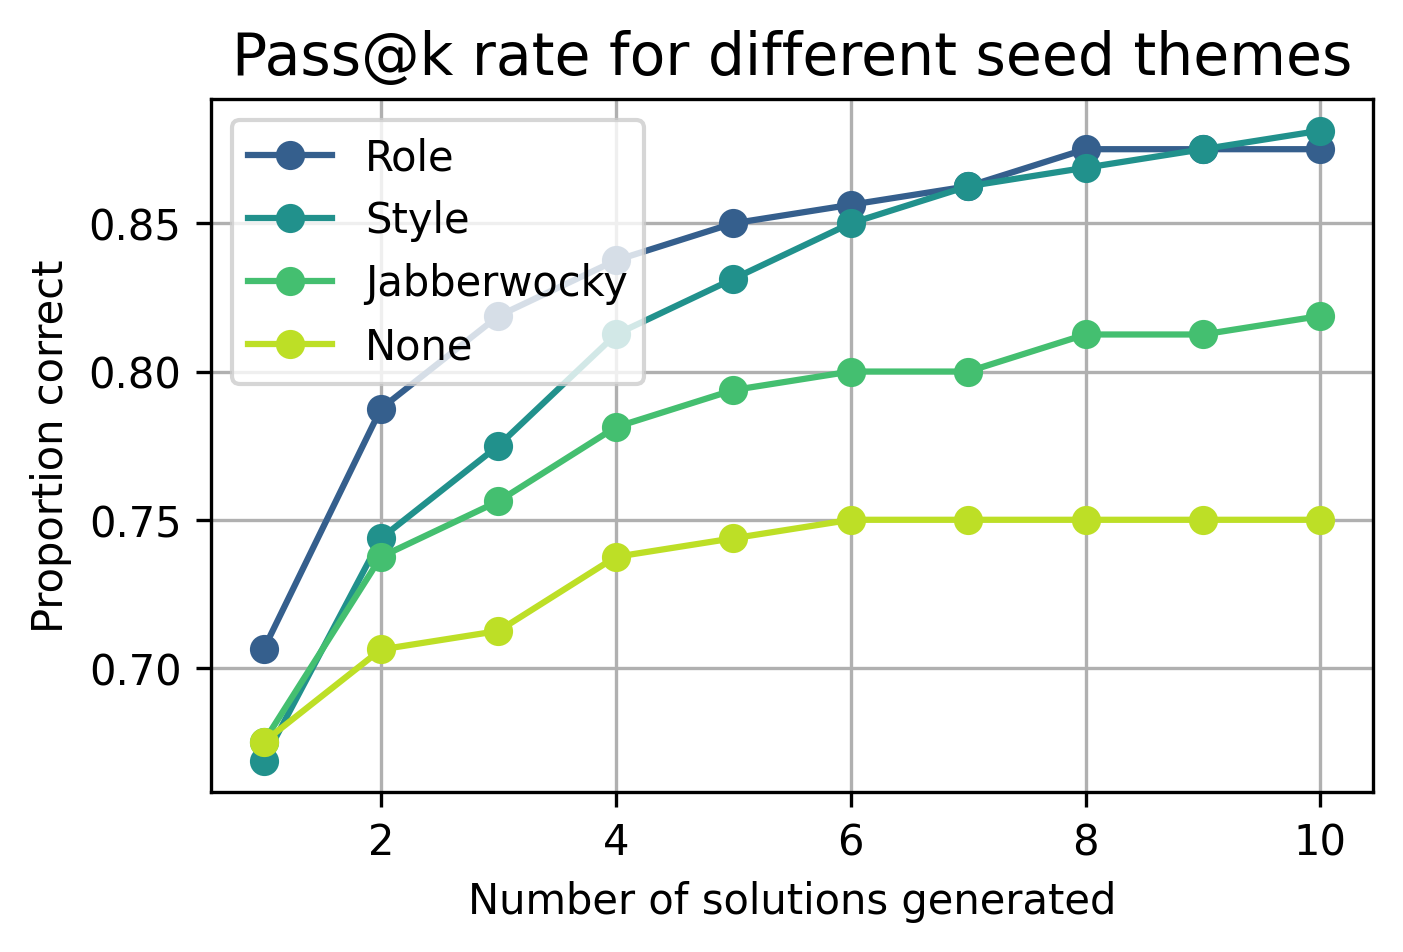

In [7]:
new_data = {
    
    "Role": {0: 0.70625, 1: 0.08125, 7: 0.0125, 2: 0.03125, None: 0.125, 3: 0.01875, 4: 0.0125, 6: 0.00625, 5: 0.00625},
    "Style": {0: 0.66875, 2: 0.03125, None: 0.11875, 3: 0.0375, 5: 0.01875, 6: 0.0125, 1: 0.075, 9: 0.00625, 4: 0.01875, 7: 0.00625, 8: 0.00625},
    "Jabberwocky": {0: 0.675, 3: 0.025, None: 0.18125, 1: 0.0625, 9: 0.00625, 7: 0.0125, 4: 0.0125, 2: 0.01875, 5: 0.00625},
    "None": {0: 0.675, 5: 0.00625, None: 0.25, 1: 0.03125, 2: 0.00625, 4: 0.00625, 3: 0.025},
    
}
create_graph(new_data, title="Pass@k rate for different seed themes", ordered_data=["Role", "Style", "Jabberwocky", "None"])

## Recreating token cost chart

You can also recreate the token cost chart by copying the "token_cost_histogram" output.

Figure saved as scaling_curves.pdf


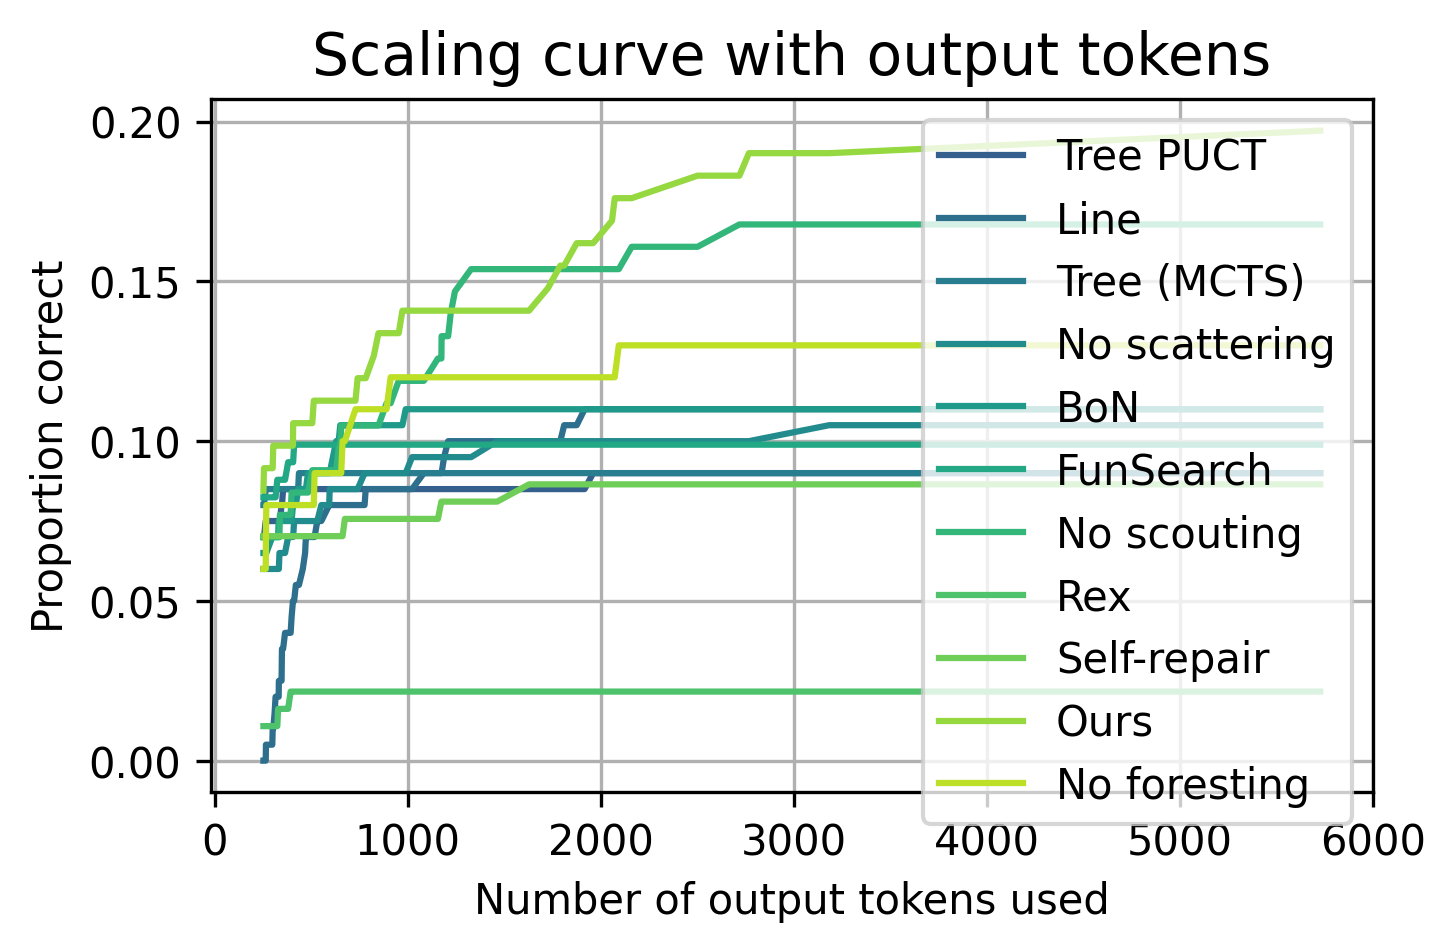

In [50]:
new_data = {
    
    "Tree PUCT": {None: 0.905, 205: 0.005, 346: 0.005, 193: 0.005, 115: 0.01, 156: 0.005, 354: 0.005, 264: 0.005, 58: 0.005, 71: 0.01, 244: 0.005, 96: 0.005, 59: 0.005, 169: 0.005, 138: 0.005, 1960: 0.005, 231: 0.005},
    "Line": {405: 0.005, None: 0.89, 420: 0.005, 1188: 0.005, 782: 0.005, 1810: 0.005, 531: 0.005, 1916: 0.005, 398: 0.005, 456: 0.005, 310: 0.005, 472: 0.005, 265: 0.005, 348: 0.005, 1209: 0.005, 315: 0.005, 347: 0.005, 300: 0.005, 332: 0.005, 364: 0.005, 468: 0.005, 1083: 0.005, 593: 0.005},
    "Tree (MCTS)": {161: 0.005, None: 0.905, 114: 0.005, 193: 0.005, 124: 0.005, 104: 0.005, 264: 0.005, 167: 0.005, 115: 0.005, 66: 0.005, 58: 0.005, 71: 0.01, 96: 0.005, 59: 0.005, 169: 0.005, 133: 0.005, 436: 0.005, 213: 0.005},
    "No scattering": {595: 0.005, None: 0.89, 114: 0.005, 1463: 0.005, 776: 0.005, 193: 0.005, 115: 0.005, 1022: 0.005, 380: 0.005, 335: 0.005, 3183: 0.005, 113: 0.005, 552: 0.005, 58: 0.005, 71: 0.01, 96: 0.005, 129: 0.005, 169: 0.005, 133: 0.005, 411: 0.005, 213: 0.005},
    "BoN": {650: 0.005, None: 0.885, 214: 0.005, 193: 0.005, 405: 0.005, 249: 0.005, 432: 0.005, 331: 0.005, 612: 0.005, 115: 0.005, 298: 0.005, 58: 0.005, 989: 0.005, 71: 0.01, 244: 0.005, 483: 0.005, 96: 0.005, 199: 0.005, 169: 0.005, 138: 0.005, 629: 0.005, 213: 0.005},
    "FunSearch": {324: 0.005494505494505495, None: 0.8956043956043956, 114: 0.005494505494505495, 193: 0.005494505494505495, 153: 0.005494505494505495, 143: 0.005494505494505495, 380: 0.005494505494505495, 115: 0.005494505494505495, 252: 0.005494505494505495, 66: 0.005494505494505495, 58: 0.005494505494505495, 71: 0.01098901098901099, 219: 0.005494505494505495, 96: 0.005494505494505495, 169: 0.005494505494505495, 138: 0.005494505494505495, 118: 0.005494505494505495, 411: 0.005494505494505495},
    "No scouting": {398: 0.006993006993006993, 505: 0.006993006993006993, None: 0.8251748251748252, 114: 0.006993006993006993, 890: 0.006993006993006993, 2160: 0.006993006993006993, 193: 0.006993006993006993, 953: 0.006993006993006993, 115: 0.006993006993006993, 126: 0.006993006993006993, 655: 0.006993006993006993, 1244: 0.006993006993006993, 642: 0.006993006993006993, 2718: 0.006993006993006993, 113: 0.006993006993006993, 1175: 0.006993006993006993, 1222: 0.006993006993006993, 66: 0.006993006993006993, 1156: 0.006993006993006993, 1328: 0.006993006993006993, 58: 0.006993006993006993, 94: 0.006993006993006993, 71: 0.006993006993006993, 337: 0.006993006993006993, 96: 0.006993006993006993},
    "Rex": {None: 0.9243243243243243, 393: 0.005405405405405406, 104: 0.005405405405405406, 328: 0.005405405405405406, 163: 0.005405405405405406},
    "Self-repair": {161: 0.005405405405405406, None: 0.9081081081081082, 114: 0.005405405405405406, 193: 0.010810810810810811, 115: 0.010810810810810811, 126: 0.005405405405405406, 674: 0.005405405405405406, 1628: 0.005405405405405406, 58: 0.005405405405405406, 71: 0.010810810810810811, 96: 0.005405405405405406, 169: 0.005405405405405406, 138: 0.005405405405405406, 1174: 0.005405405405405406},
    "Ours": {161: 0.007042253521126761, 406: 0.007042253521126761, None: 0.795774647887324, 159: 0.007042253521126761, 163: 0.007042253521126761, 2501: 0.007042253521126761, 194: 0.007042253521126761, 255: 0.007042253521126761, 303: 0.007042253521126761, 740: 0.007042253521126761, 848: 0.007042253521126761, 2767: 0.007042253521126761, 5727: 0.007042253521126761, 167: 0.007042253521126761, 1790: 0.007042253521126761, 115: 0.007042253521126761, 513: 0.007042253521126761, 1875: 0.007042253521126761, 1726: 0.007042253521126761, 972: 0.007042253521126761, 171: 0.007042253521126761, 58: 0.007042253521126761, 2072: 0.007042253521126761, 89: 0.007042253521126761, 71: 0.007042253521126761, 2058: 0.007042253521126761, 824: 0.007042253521126761, 117: 0.007042253521126761, 213: 0.007042253521126761},
    "No foresting": {161: 0.01, None: 0.86, 163: 0.01, 265: 0.01, 64: 0.01, 107: 0.01, 729: 0.01, 911: 0.01, 517: 0.01, 2093: 0.01, 123: 0.01, 267: 0.01, 144: 0.01, 662: 0.01},
}
create_token_graph(new_data, title="Scaling curve with output tokens", ordered_data=["Tree PUCT",  "Line", "Tree (MCTS)", "No scattering", "BoN", "FunSearch", "No scouting", "Rex", "Self-repair", "Ours", "No foresting"], save_as="pdf")

Figure saved as scaling_curves.pdf


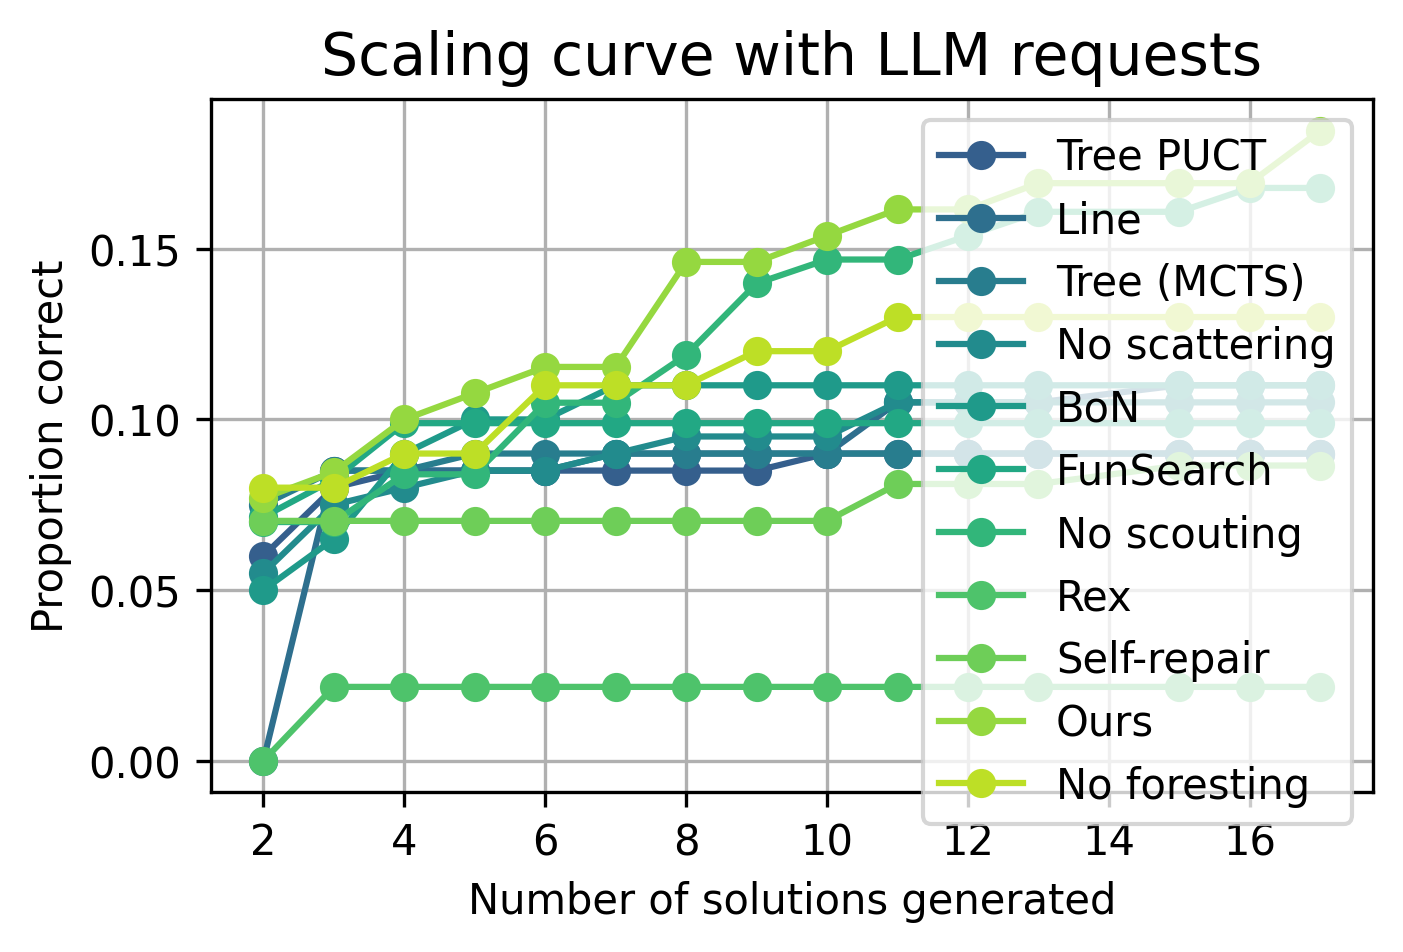

In [6]:
new_data = {
    
    "Tree PUCT": {None: 0.905, 2: 0.02, 1: 0.06, 3: 0.005, 9: 0.005},
    "Line": {2: 0.085, None: 0.89, 10: 0.015, 14: 0.005, 6: 0.005},
    "Tree (MCTS)": {1: 0.075, None: 0.905, 2: 0.01, 4: 0.005},
    "No scattering": {4: 0.005, None: 0.89, 1: 0.055, 10: 0.01, 2: 0.02, 7: 0.005, 3: 0.005, 6: 0.005},
    "BoN": {4: 0.01, None: 0.885, 2: 0.015, 1: 0.05, 6: 0.01, 3: 0.025},
    "FunSearch": {2: 0.01098901098901099, None: 0.8956043956043956, 1: 0.07142857142857142, 3: 0.016483516483516484},
    "No scouting": {3: 0.013986013986013986, 5: 0.02097902097902098, None: 0.8251748251748252, 1: 0.06993006993006994, 12: 0.006993006993006993, 8: 0.02097902097902098, 15: 0.006993006993006993, 7: 0.013986013986013986, 9: 0.006993006993006993, 11: 0.006993006993006993},
    "Rex": {None: 0.9243243243243243, 2: 0.021621621621621623},
    "Self-repair": {1: 0.07027027027027027, None: 0.9081081081081082, 10: 0.010810810810810811, 14: 0.005405405405405406},
    "Ours": {1: 0.07692307692307693, 3: 0.015384615384615385, None: 0.8076923076923077, 12: 0.007692307692307693, 4: 0.007692307692307693, 7: 0.03076923076923077, 5: 0.007692307692307693, 16: 0.015384615384615385, 2: 0.007692307692307693, 10: 0.007692307692307693, 9: 0.007692307692307693},
    "No foresting": {1: 0.08, None: 0.86, 5: 0.02, 8: 0.01, 3: 0.01, 10: 0.01},
}
create_graph(new_data, title="Scaling curve with LLM requests", ordered_data=["Tree PUCT",  "Line", "Tree (MCTS)", "No scattering", "BoN", "FunSearch", "No scouting", "Rex", "Self-repair", "Ours", "No foresting"], save_as="pdf")

Figure saved as scaling_curves.pdf


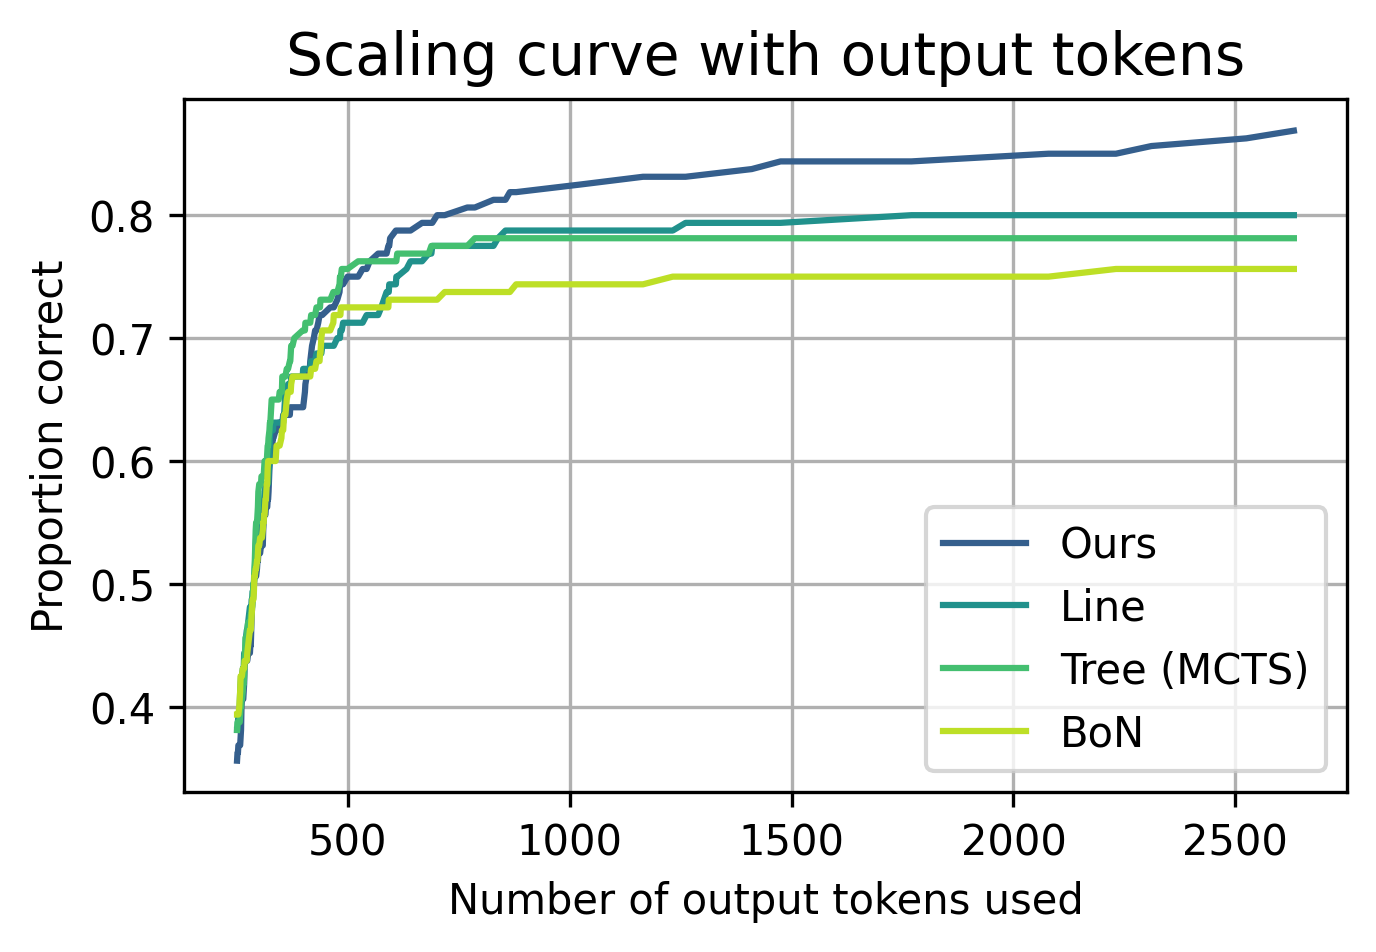

In [2]:
new_data = {
    
    "Ours": {130: 0.00625, 239: 0.00625, 251: 0.00625, 246: 0.00625, 423: 0.00625, 220: 0.0125, None: 0.13125, 221: 0.00625, 337: 0.00625, 176: 0.00625, 195: 0.0125, 187: 0.00625, 2632: 0.00625, 769: 0.00625, 155: 0.00625, 414: 0.00625, 200: 0.00625, 288: 0.00625, 283: 0.0125, 287: 0.00625, 331: 0.00625, 238: 0.01875, 533: 0.00625, 417: 0.00625, 132: 0.00625, 222: 0.0125, 153: 0.0125, 404: 0.00625, 205: 0.00625, 568: 0.00625, 309: 0.0125, 2079: 0.00625, 321: 0.00625, 415: 0.00625, 247: 0.00625, 289: 0.00625, 1475: 0.00625, 199: 0.00625, 228: 0.00625, 179: 0.00625, 298: 0.00625, 667: 0.00625, 1165: 0.00625, 433: 0.00625, 311: 0.00625, 229: 0.00625, 234: 0.0125, 296: 0.00625, 230: 0.00625, 275: 0.00625, 182: 0.00625, 282: 0.0125, 2311: 0.00625, 259: 0.00625, 253: 0.00625, 180: 0.00625, 202: 0.00625, 280: 0.00625, 608: 0.00625, 225: 0.00625, 401: 0.00625, 324: 0.00625, 160: 0.00625, 436: 0.00625, 828: 0.00625, 241: 0.00625, 310: 0.00625, 2525: 0.00625, 285: 0.00625, 208: 0.00625, 460: 0.00625, 260: 0.01875, 242: 0.01875, 403: 0.00625, 323: 0.01875, 426: 0.00625, 152: 0.00625, 177: 0.00625, 178: 0.00625, 236: 0.0125, 267: 0.0125, 591: 0.00625, 419: 0.00625, 219: 0.00625, 304: 0.00625, 865: 0.00625, 482: 0.00625, 258: 0.00625, 237: 0.0125, 315: 0.00625, 181: 0.00625, 701: 0.00625, 319: 0.00625, 232: 0.00625, 1410: 0.00625, 185: 0.00625, 268: 0.00625, 1025: 0.00625, 595: 0.00625, 227: 0.00625, 194: 0.00625, 344: 0.00625, 209: 0.0125, 326: 0.00625, 407: 0.00625, 265: 0.00625, 284: 0.00625, 189: 0.00625, 266: 0.00625, 549: 0.00625, 329: 0.00625, 476: 0.00625, 295: 0.00625, 499: 0.00625, 184: 0.00625, 261: 0.00625, 354: 0.00625, 481: 0.00625, 370: 0.00625, 204: 0.00625},
    "Line": {148: 0.0125, 1770: 0.00625, 292: 0.025, 246: 0.00625, 205: 0.0125, None: 0.2, 216: 0.01875, 311: 0.00625, 209: 0.0125, 214: 0.0125, 187: 0.00625, 223: 0.00625, 587: 0.0125, 372: 0.00625, 146: 0.00625, 417: 0.00625, 203: 0.0125, 263: 0.00625, 266: 0.0125, 283: 0.00625, 230: 0.00625, 312: 0.00625, 399: 0.00625, 304: 0.0125, 137: 0.00625, 226: 0.0125, 153: 0.00625, 682: 0.00625, 575: 0.00625, 641: 0.00625, 325: 0.00625, 838: 0.00625, 257: 0.0125, 289: 0.00625, 314: 0.00625, 690: 0.00625, 287: 0.00625, 173: 0.00625, 270: 0.0125, 476: 0.00625, 632: 0.00625, 306: 0.00625, 236: 0.01875, 163: 0.0125, 855: 0.00625, 234: 0.0125, 308: 0.00625, 275: 0.00625, 182: 0.00625, 489: 0.00625, 253: 0.00625, 180: 0.00625, 202: 0.00625, 165: 0.00625, 324: 0.01875, 160: 0.00625, 358: 0.0125, 442: 0.00625, 240: 0.0125, 542: 0.00625, 207: 0.00625, 332: 0.00625, 258: 0.00625, 244: 0.00625, 279: 0.00625, 233: 0.00625, 323: 0.0125, 189: 0.0125, 152: 0.00625, 206: 0.00625, 181: 0.00625, 609: 0.00625, 250: 0.00625, 252: 0.00625, 359: 0.00625, 483: 0.00625, 259: 0.00625, 293: 0.00625, 593: 0.00625, 239: 0.00625, 321: 0.00625, 232: 0.00625, 227: 0.0125, 210: 0.0125, 238: 0.00625, 1261: 0.00625, 194: 0.00625, 365: 0.00625, 188: 0.00625, 164: 0.00625, 228: 0.00625, 235: 0.00625, 162: 0.00625, 272: 0.00625, 277: 0.00625, 355: 0.00625, 186: 0.00625, 285: 0.00625, 256: 0.00625, 429: 0.00625, 201: 0.00625},
    "Tree (MCTS)": {155: 0.00625, None: 0.21875, 292: 0.025, 246: 0.00625, 201: 0.0125, 318: 0.00625, 228: 0.01875, 311: 0.00625, 214: 0.01875, 186: 0.0125, 224: 0.0125, 372: 0.00625, 139: 0.00625, 417: 0.00625, 260: 0.00625, 269: 0.0125, 286: 0.00625, 352: 0.0125, 281: 0.00625, 222: 0.0125, 312: 0.00625, 267: 0.0125, 226: 0.0125, 153: 0.00625, 205: 0.00625, 404: 0.00625, 327: 0.00625, 688: 0.00625, 266: 0.00625, 289: 0.0125, 297: 0.00625, 273: 0.00625, 173: 0.00625, 298: 0.0125, 438: 0.00625, 236: 0.0125, 163: 0.0125, 234: 0.0125, 268: 0.00625, 275: 0.00625, 182: 0.0125, 219: 0.00625, 296: 0.00625, 202: 0.0125, 257: 0.00625, 165: 0.0125, 215: 0.00625, 324: 0.00625, 398: 0.00625, 241: 0.00625, 481: 0.00625, 285: 0.00625, 207: 0.00625, 328: 0.00625, 258: 0.00625, 244: 0.0125, 283: 0.00625, 243: 0.00625, 323: 0.00625, 611: 0.00625, 188: 0.0125, 152: 0.00625, 148: 0.00625, 191: 0.0125, 467: 0.00625, 486: 0.00625, 287: 0.00625, 245: 0.00625, 379: 0.00625, 482: 0.00625, 264: 0.00625, 167: 0.00625, 523: 0.00625, 239: 0.00625, 321: 0.00625, 233: 0.00625, 204: 0.00625, 263: 0.00625, 227: 0.00625, 197: 0.00625, 362: 0.00625, 209: 0.00625, 319: 0.00625, 371: 0.00625, 190: 0.00625, 305: 0.00625, 164: 0.00625, 235: 0.00625, 172: 0.00625, 290: 0.00625, 300: 0.00625, 293: 0.00625, 369: 0.00625, 786: 0.00625, 346: 0.00625, 251: 0.00625, 429: 0.00625, 199: 0.00625, 326: 0.00625, 210: 0.00625},
    "BoN": {148: 0.0125, None: 0.24375, 437: 0.00625, 246: 0.00625, 209: 0.025, 308: 0.00625, 468: 0.00625, 218: 0.00625, 592: 0.00625, 319: 0.0125, 214: 0.0125, 183: 0.00625, 224: 0.00625, 362: 0.0125, 146: 0.00625, 417: 0.00625, 203: 0.00625, 263: 0.00625, 288: 0.00625, 229: 0.00625, 211: 0.00625, 230: 0.00625, 351: 0.00625, 467: 0.00625, 279: 0.00625, 132: 0.00625, 205: 0.0125, 153: 0.00625, 2231: 0.00625, 309: 0.00625, 267: 0.00625, 289: 0.0125, 313: 0.00625, 314: 0.00625, 226: 0.00625, 173: 0.00625, 298: 0.00625, 440: 0.0125, 1232: 0.00625, 311: 0.00625, 236: 0.0125, 163: 0.0125, 234: 0.0125, 277: 0.00625, 275: 0.00625, 157: 0.00625, 442: 0.00625, 225: 0.0125, 273: 0.00625, 182: 0.00625, 207: 0.0125, 257: 0.00625, 165: 0.00625, 282: 0.00625, 160: 0.00625, 375: 0.00625, 239: 0.00625, 285: 0.00625, 350: 0.00625, 258: 0.0125, 248: 0.00625, 283: 0.00625, 247: 0.00625, 284: 0.00625, 189: 0.00625, 150: 0.00625, 718: 0.00625, 188: 0.0125, 204: 0.00625, 181: 0.00625, 372: 0.00625, 250: 0.00625, 255: 0.00625, 356: 0.00625, 484: 0.00625, 316: 0.00625, 233: 0.00625, 320: 0.00625, 208: 0.0125, 228: 0.00625, 240: 0.00625, 227: 0.0125, 194: 0.00625, 365: 0.00625, 190: 0.01875, 302: 0.00625, 164: 0.00625, 232: 0.00625, 212: 0.00625, 879: 0.00625, 292: 0.00625, 297: 0.00625, 222: 0.00625, 295: 0.00625, 355: 0.00625, 338: 0.00625, 317: 0.00625, 256: 0.00625, 429: 0.00625, 200: 0.00625, 339: 0.00625},
    
}
create_token_graph(new_data, title="Scaling curve with output tokens", ordered_data=["Ours",  "Line", "Tree (MCTS)", "BoN"])

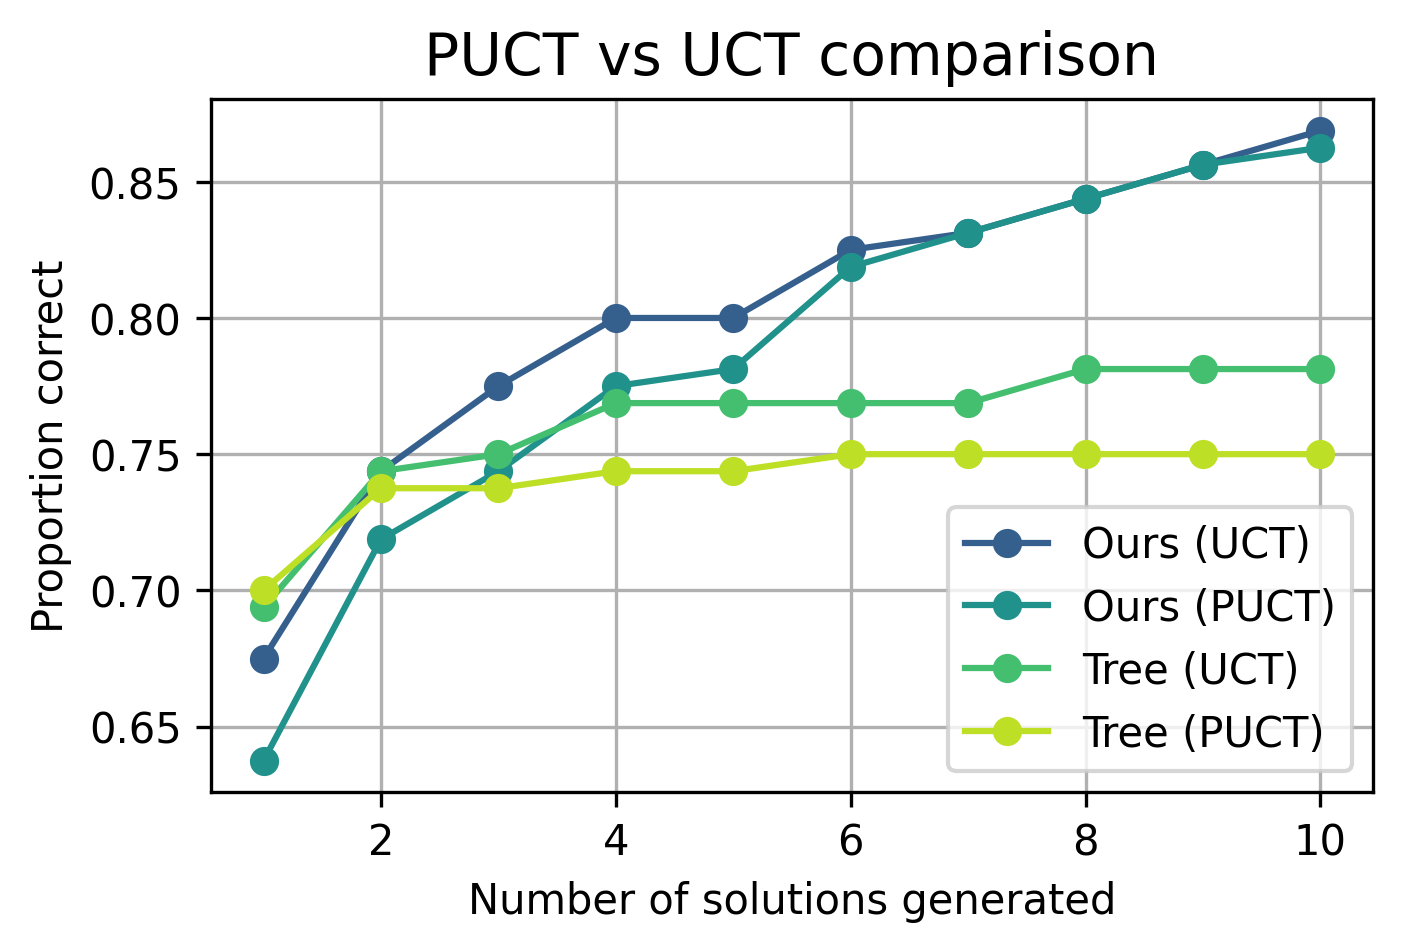

In [31]:
new_data = {
    
    "Ours (PUCT)": {0: 0.6375, 1: 0.08125, 3: 0.03125, None: 0.1375, 5: 0.0375, 7: 0.0125, 2: 0.025, 8: 0.0125, 4: 0.00625, 9: 0.00625, 6: 0.0125},
    "Ours (UCT)": {0: 0.675, 2: 0.03125, None: 0.13125, 9: 0.0125, 3: 0.025, 1: 0.06875, 7: 0.0125, 6: 0.00625, 8: 0.0125, 5: 0.025},
    "Tree (PUCT)": {0: 0.7, None: 0.25, 1: 0.0375, 3: 0.00625, 5: 0.00625},
    "Tree (UCT)": {0: 0.69375, None: 0.21875, 1: 0.05, 3: 0.01875, 7: 0.0125, 2: 0.00625},
    
}
create_graph(new_data, title="PUCT vs UCT comparison", ordered_data=["Ours (UCT)", "Ours (PUCT)", "Tree (UCT)", "Tree (PUCT)"])

Figure saved as scaling_curves.pdf


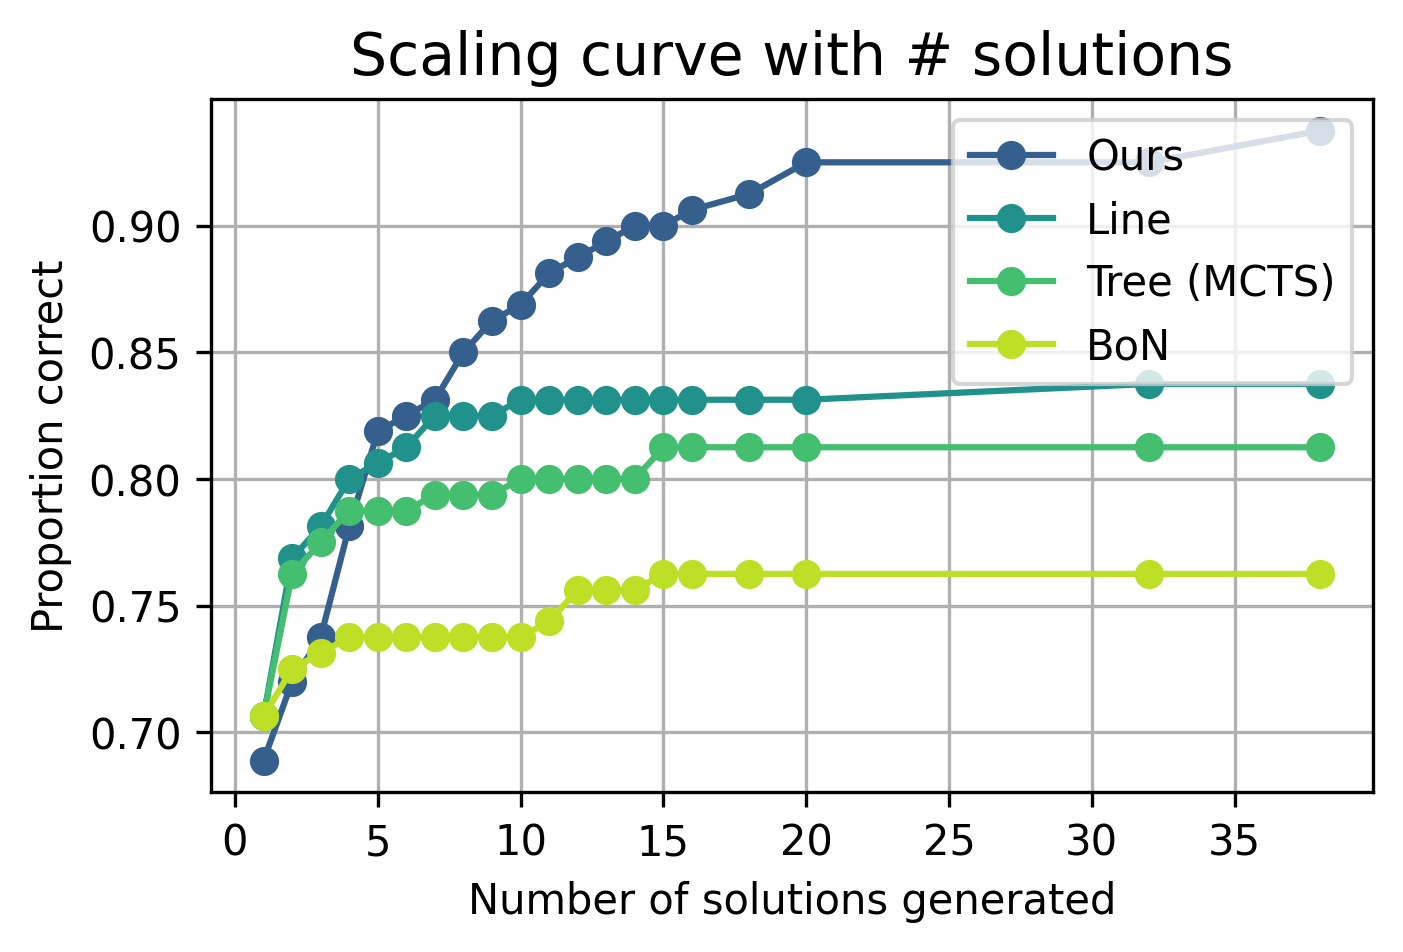

In [10]:
new_data = {
    
    "Ours": {0: 0.68875, 8: 0.0125, 3: 0.04375, 4: 0.0375, 1: 0.03125, None: 0.0625, 2: 0.0175, 7: 0.01875, 11: 0.00625, 9: 0.00625, 13: 0.00625, 5: 0.00625, 17: 0.00625, 19: 0.0125, 10: 0.0125, 12: 0.00625, 6: 0.00625, 37: 0.0125, 15: 0.00625},
    "Line": {0: 0.70625, 3: 0.01875, 9: 0.00625, None: 0.1625, 1: 0.0625, 2: 0.0125, 6: 0.0125, 5: 0.00625, 4: 0.00625, 31: 0.00625},
    "Tree (MCTS)": {0: 0.70625, 6: 0.00625, None: 0.1875, 1: 0.05625, 3: 0.0125, 14: 0.0125, 2: 0.0125, 9: 0.00625},
    "BoN": {0: 0.70625, None: 0.2375, 1: 0.01875, 10: 0.00625, 3: 0.00625, 11: 0.0125, 2: 0.00625, 14: 0.00625},
    
}
create_graph(new_data, title="Scaling curve with # solutions", ordered_data=["Ours", "Line", "Tree (MCTS)", "BoN"])

Figure saved as scaling_curves.pdf


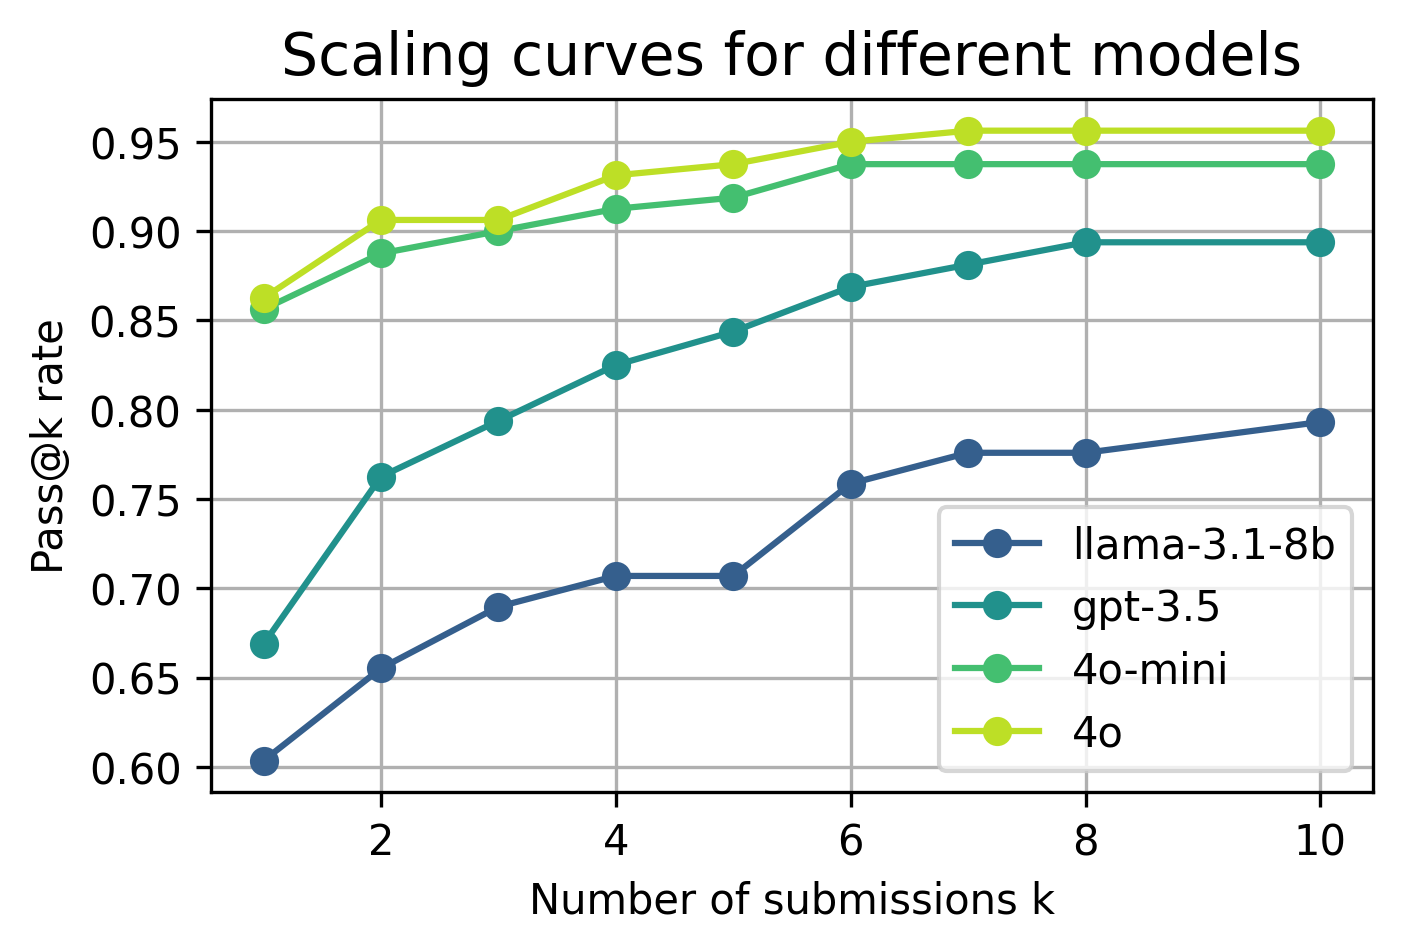

In [17]:
# Call the function
new_data = {
    "llama-3.1-8b": {0: 0.603448275862069, 1: 0.05172413793103448, 3: 0.017241379310344827, 2: 0.034482758620689655, 5: 0.05172413793103448, None: 0.15517241379310345, 9: 0.017241379310344827, 6: 0.017241379310344827},
    "gpt-3.5": {0: 0.66875, 1: 0.09375, 7: 0.0125, None: 0.10625, 3: 0.03125, 2: 0.03125, 5: 0.025, 4: 0.01875, 6: 0.0125},
    "4o-mini": {0: 0.85625, None: 0.0625, 2: 0.0125, 3: 0.0125, 5: 0.01875, 1: 0.03125, 4: 0.00625},
    "4o": {0: 0.8625, None: 0.04375, 3: 0.025, 1: 0.04375, 4: 0.00625, 5: 0.0125, 6: 0.00625}
}
create_graph(new_data, title="Scaling curves for different models")

Figure saved as scaling_curves.pdf


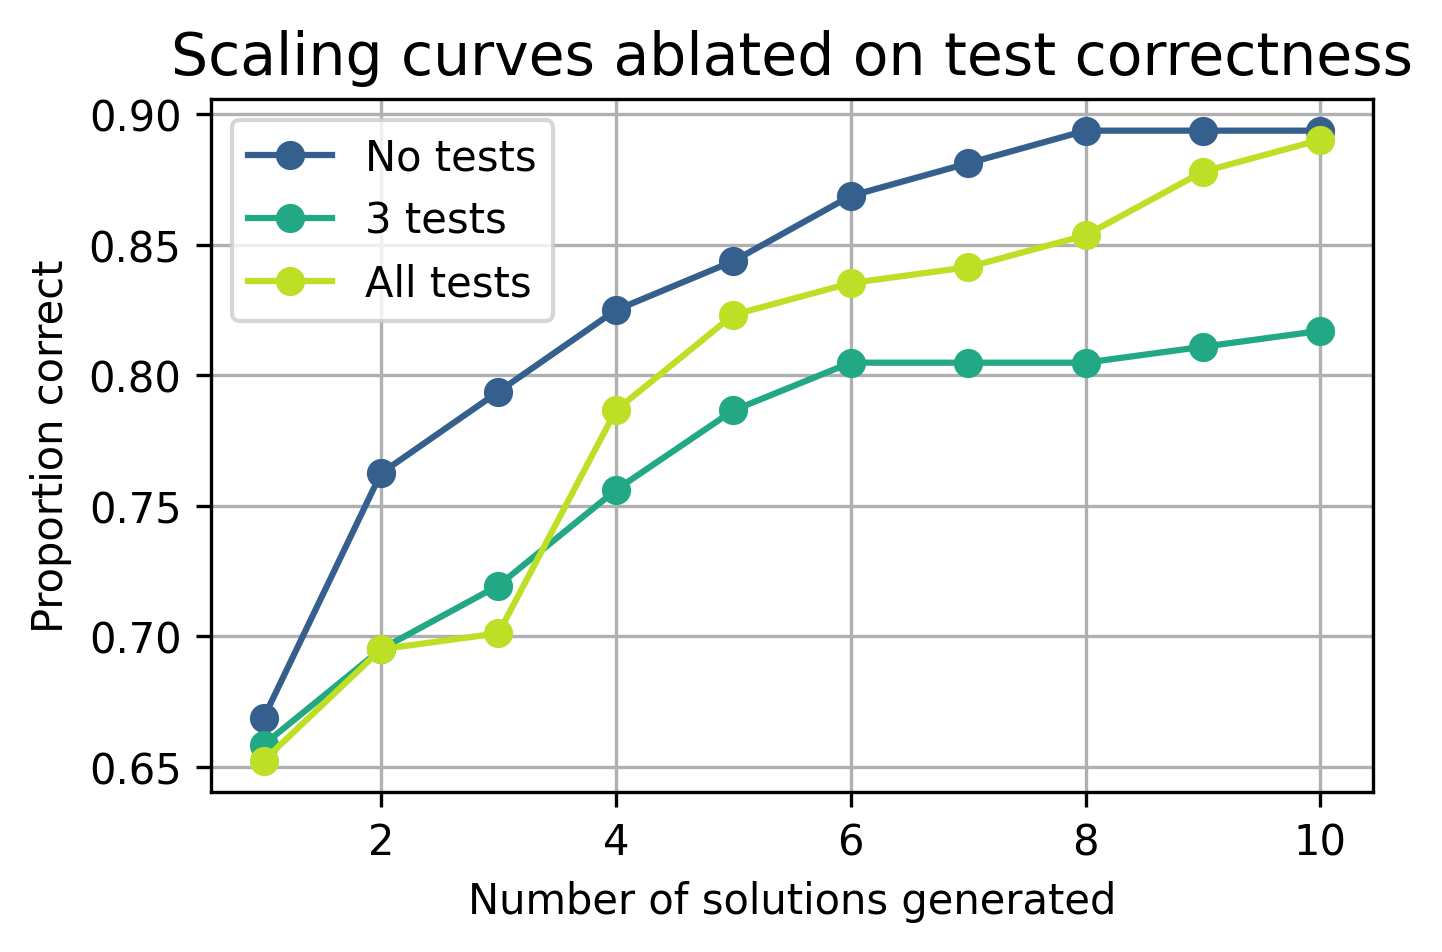

In [7]:
# Call the function
new_data = {
    "No tests": {0: 0.66875, 1: 0.09375, 7: 0.0125, None: 0.10625, 3: 0.03125, 2: 0.03125, 5: 0.025, 4: 0.01875, 6: 0.0125},
    "3 tests": {0: 0.6585365853658537, 4: 0.03048780487804878, None: 0.18292682926829268, 1: 0.036585365853658534, 9: 0.006097560975609756, 8: 0.006097560975609756, 3: 0.036585365853658534, 5: 0.018292682926829267, 2: 0.024390243902439025},
    "All tests": {0: 0.6524390243902439, 8: 0.024390243902439025, 3: 0.08536585365853659, 4: 0.036585365853658534, 1: 0.042682926829268296, 7: 0.012195121951219513, None: 0.10975609756097561, 5: 0.012195121951219513, 2: 0.006097560975609756, 9: 0.012195121951219513, 6: 0.006097560975609756}
}
create_graph(new_data, title="Scaling curves ablated on test correctness")

Figure saved as scaling_curves.pdf


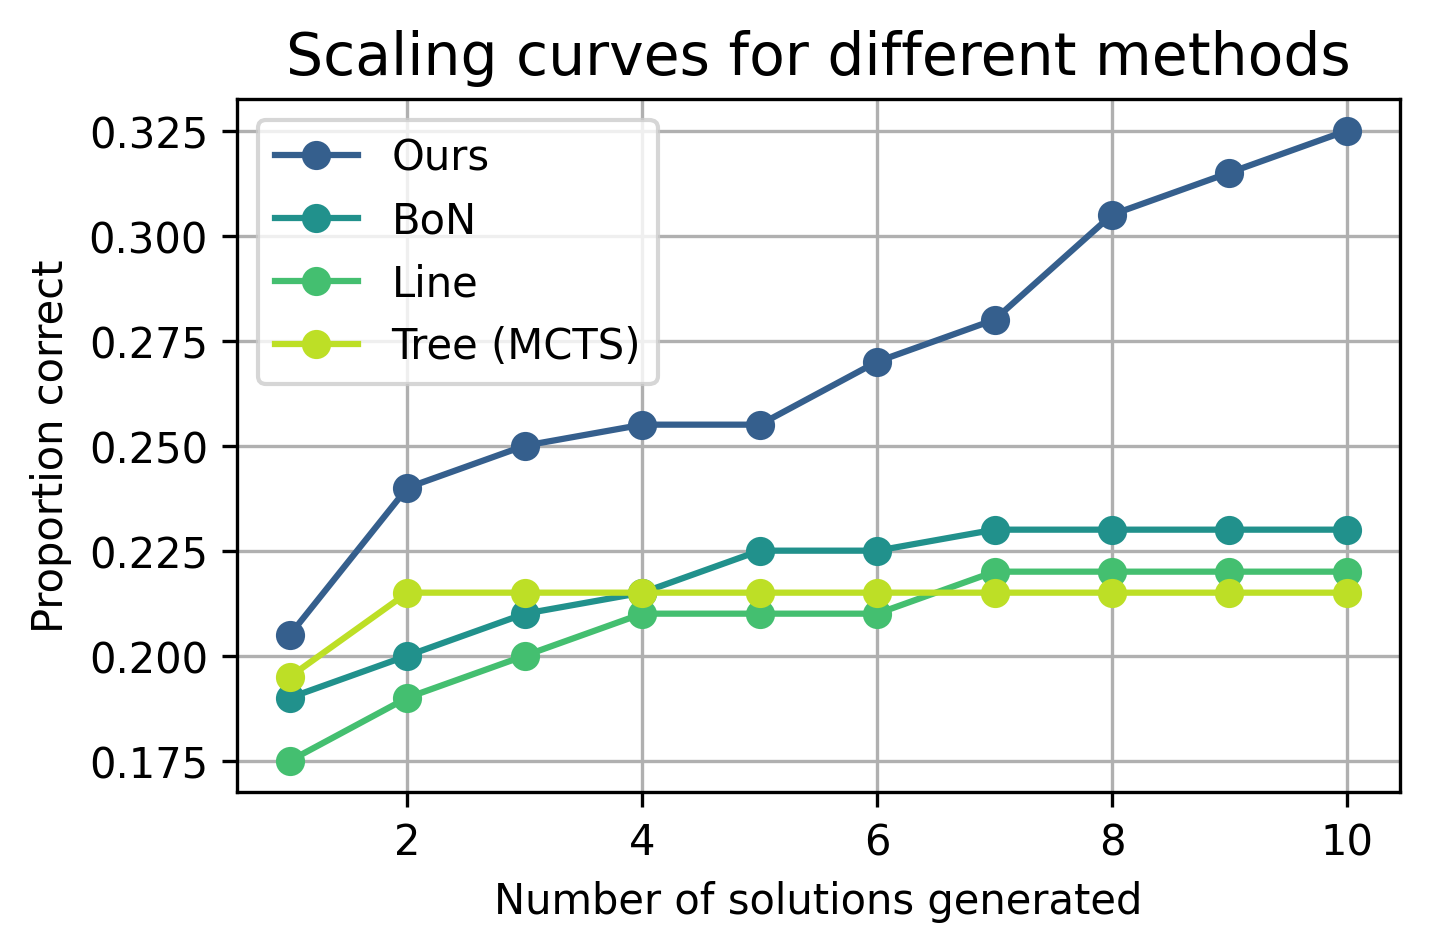

In [11]:
# Call the function
new_data = {
    "Ours": {None: 0.675, 0: 0.205, 5: 0.015, 1: 0.035, 3: 0.005, 9: 0.01, 7: 0.025, 6: 0.01, 8: 0.01, 2: 0.01},
    "BoN": {None: 0.77, 0: 0.19, 1: 0.01, 4: 0.01, 2: 0.01, 3: 0.005, 6: 0.005},
    "Line": {None: 0.77, 0: 0.175, 2: 0.01, 6: 0.01, 3: 0.01, 1: 0.015},
    "Tree (MCTS)": {None: 0.785, 0: 0.195, 1: 0.02},
}
create_graph(new_data, title="Scaling curves for different methods")

Figure saved as scaling_curves.pdf


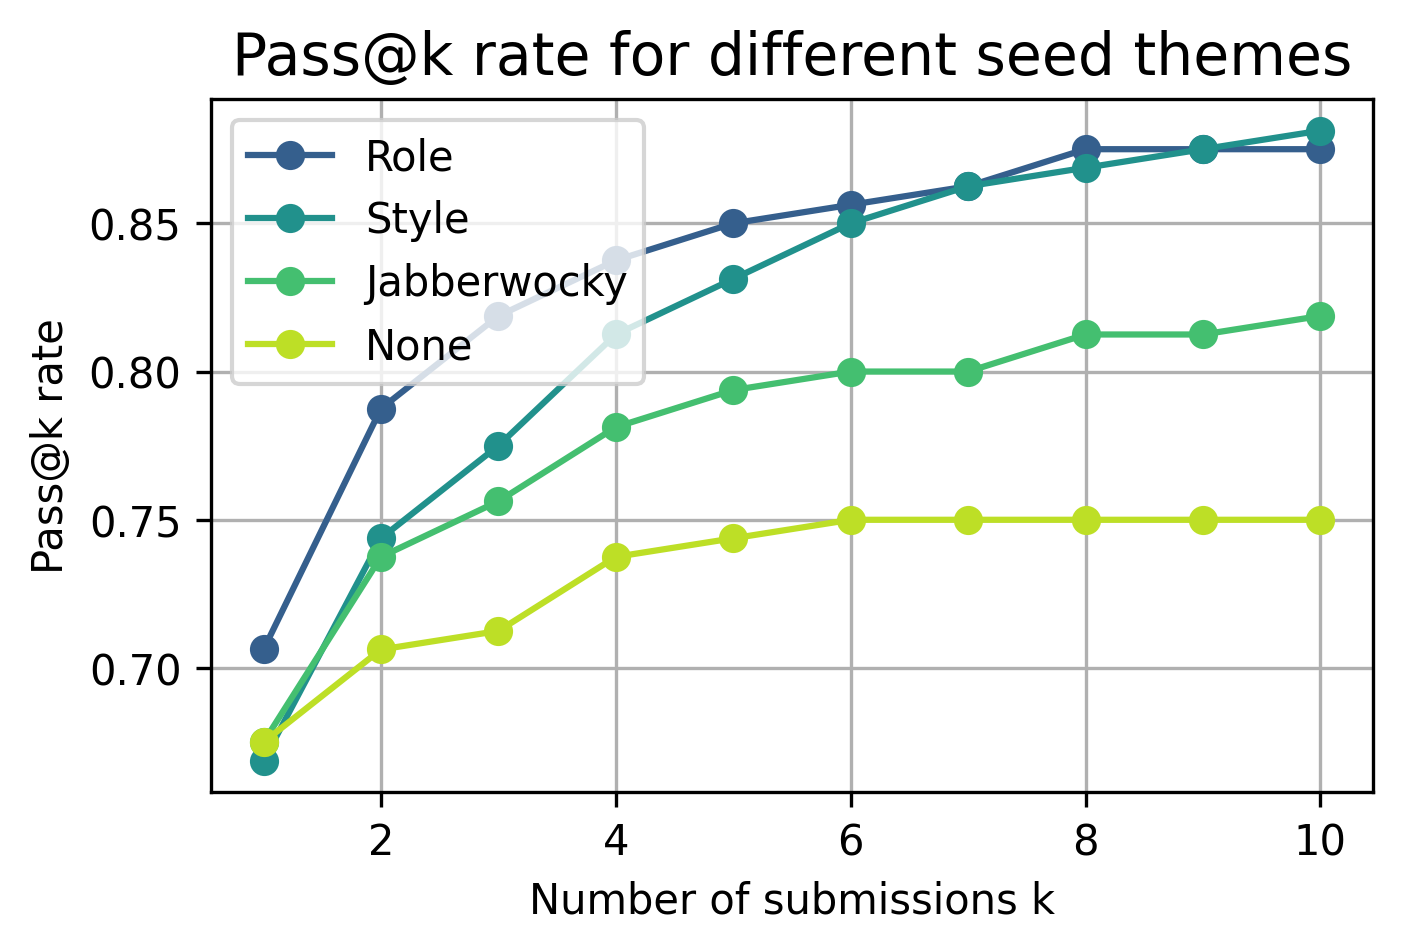

In [13]:
new_data = {
    
    "Role": {0: 0.70625, 1: 0.08125, 7: 0.0125, 2: 0.03125, None: 0.125, 3: 0.01875, 4: 0.0125, 6: 0.00625, 5: 0.00625},
    "Style": {0: 0.66875, 2: 0.03125, None: 0.11875, 3: 0.0375, 5: 0.01875, 6: 0.0125, 1: 0.075, 9: 0.00625, 4: 0.01875, 7: 0.00625, 8: 0.00625},
    "Jabberwocky": {0: 0.675, 3: 0.025, None: 0.18125, 1: 0.0625, 9: 0.00625, 7: 0.0125, 4: 0.0125, 2: 0.01875, 5: 0.00625},
    "None": {0: 0.675, 5: 0.00625, None: 0.25, 1: 0.03125, 2: 0.00625, 4: 0.00625, 3: 0.025},
    
}
create_graph(new_data, title="Pass@k rate for different seed themes", ordered_data=["Role", "Style", "Jabberwocky", "None"])

Figure saved as scaling_curves.pdf


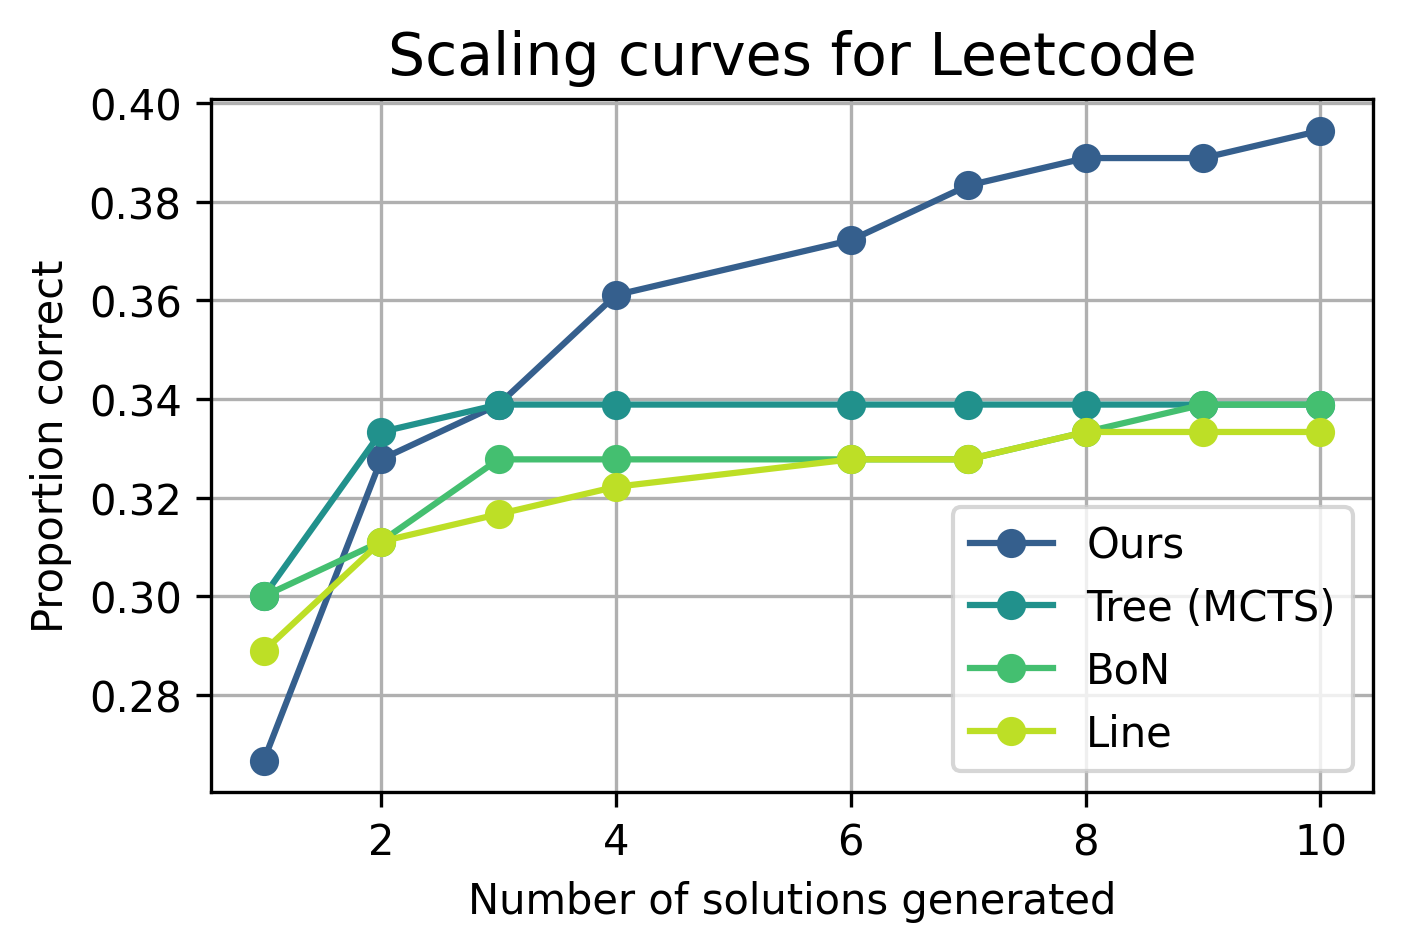

In [8]:
# Call the function
new_data = {
    "Ours": {None: 0.6055555555555555, 0: 0.26666666666666666, 5: 0.011111111111111112, 3: 0.022222222222222223, 6: 0.011111111111111112, 2: 0.011111111111111112, 1: 0.06111111111111111, 9: 0.005555555555555556, 7: 0.005555555555555556},
    "Tree (MCTS)": {None: 0.6611111111111111, 0: 0.3, 1: 0.03333333333, 2: 0.005555555556},
    "BoN": {None: 0.6555555555555556, 8: 0.005555555555555556, 0: 0.3, 1: 0.011111111111111112, 2: 0.016666666666666666, 7: 0.005555555555555556},
    "Line": {None: 0.6611111111111111, 0: 0.28888888888888886, 1: 0.022222222222222223, 3: 0.005555555555555556, 2: 0.005555555555555556, 7: 0.005555555555555556, 5: 0.005555555555555556},
}
create_graph(new_data, title="Scaling curves for Leetcode")

In [ ]:
# Call the function
new_data = {
    "Ours": {None: 0.6055555555555555, 0: 0.26666666666666666, 5: 0.011111111111111112, 3: 0.022222222222222223, 6: 0.011111111111111112, 2: 0.011111111111111112, 1: 0.06111111111111111, 9: 0.005555555555555556, 7: 0.005555555555555556},
    "Tree (MCTS)": {None: 0.6611111111111111, 0: 0.3, 1: 0.03333333333, 2: 0.005555555556},
    "BoN": {0: 0.743073047858942, None: 0.22670025188916876, 2: 0.005037783375314861, 5: 0.0025188916876574307, 1: 0.012594458438287154, 3: 0.0025188916876574307, 4: 0.0025188916876574307, 8: 0.0025188916876574307, 9: 0.0025188916876574307},
    "Line": {None: 0.6611111111111111, 0: 0.28888888888888886, 1: 0.022222222222222223, 3: 0.005555555555555556, 2: 0.005555555555555556, 7: 0.005555555555555556, 5: 0.005555555555555556},
}
create_graph(new_data, title="Scaling curves for MBPP")

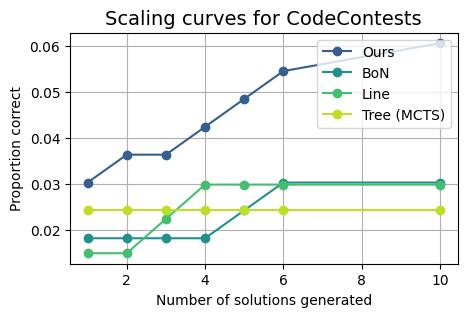

In [22]:
# Call the function
new_data = {
    "Ours": {None: 0.9393939393939394, 0: 0.030303030303030304, 4: 0.006060606060606061, 5: 0.006060606060606061, 1: 0.006060606060606061, 3: 0.006060606060606061, 9: 0.006060606060606061},
    "BoN": {None: 0.9696969696969697, 0: 0.01818181818181818, 5: 0.006060606060606061, 4: 0.006060606060606061},
    "Line": {None: 0.9552238805970149, 0: 0.014925373134328358, 2: 0.007462686567164179, 3: 0.007462686567164179},
    "Tree (MCTS)": {None: 0.9757575757575757, 0: 0.024242424242424242},
}
create_graph(new_data, title="Scaling curves for CodeContests")

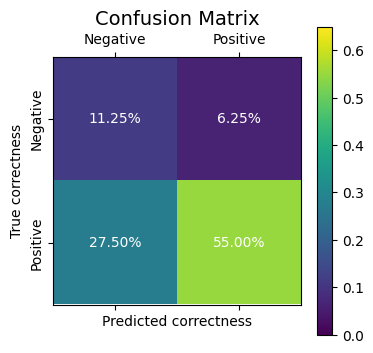

In [36]:
# Re-import necessary packages after code execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Updated data using percentages
fpr = 6.25 / 100  # False positive rate
fnr = 27.50 / 100  # False negative rate
tp = 55.00 / 100  # True positive
tn = 11.25 / 100  # True negative


confusion = np.array([[tn, fpr], [fnr, tp]])

# Re-plotting confusion matrix with percentages
fig, ax = plt.subplots(figsize=(4, 4))  # Keeping the smaller figure size
cax = ax.matshow(confusion, cmap='viridis', vmin=0, vmax=0.65)
plt.colorbar(cax)

# Annotating the matrix with percentage values
for (i, j), value in np.ndenumerate(confusion):
    ax.text(j, i, f'{value * 100:.2f}%', ha='center', va='center', color='white')

# Updating labels and title
ax.set_xlabel('Predicted correctness')
ax.set_ylabel('True correctness')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'], rotation=90, va='center')  # Centering and rotating y-axis labels

plt.title("Confusion Matrix", fontsize=14)  # Title with updated font size
plt.show()


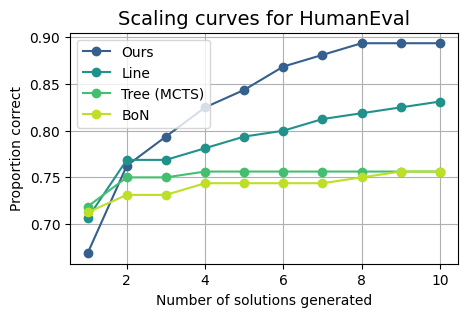

In [13]:
new_data = {
    
    "Ours": {0: 0.66875, 1: 0.09375, 7: 0.0125, None: 0.10625, 3: 0.03125, 2: 0.03125, 5: 0.025, 4: 0.01875, 6: 0.0125},
    "Line": {0: 0.70625, 1: 0.0625, None: 0.16875, 4: 0.0125, 3: 0.0125, 9: 0.00625, 5: 0.00625, 6: 0.0125, 7: 0.00625, 8: 0.00625},
    "Tree (MCTS)": {0: 0.71875, None: 0.24375, 1: 0.03125, 3: 0.00625},
    "BoN": {0: 0.7125, None: 0.24375, 1: 0.01875, 8: 0.00625, 3: 0.0125, 7: 0.00625},
    
}
create_graph(new_data, title="Scaling curves for HumanEval")